## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* **Use color transforms, gradients, etc., to create a thresholded binary image.**
* **Apply a perspective transform to rectify binary image ("birds-eye view").**
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

def show_images(images, rows = 5, cols = 4, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')
            
            

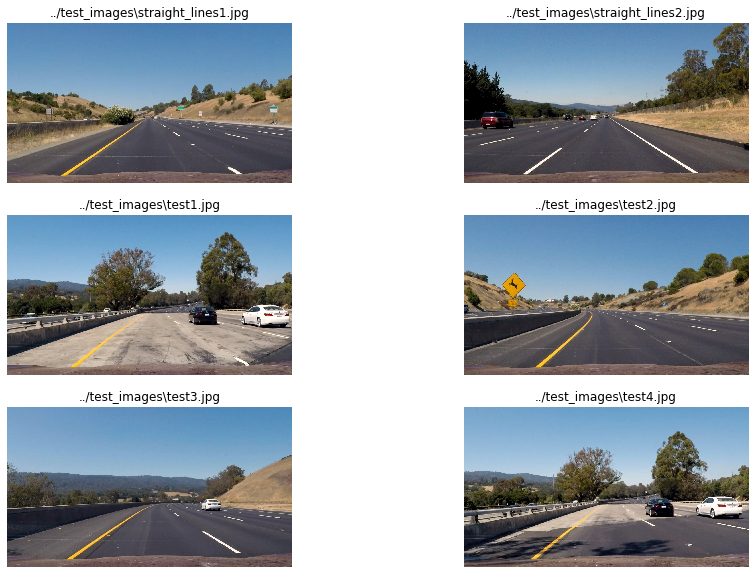

In [3]:
# Loading all test images and display them
images = glob.glob('../test_images/*.jpg')
img = list(map(lambda imageFileName: (imageFileName, cv2.cvtColor(cv2.imread(imageFileName),cv2.COLOR_BGR2RGB)), images))

show_images(img, cols=2, rows=3) 


### Undistorting the images and applying HLS Color Space for better image contrast

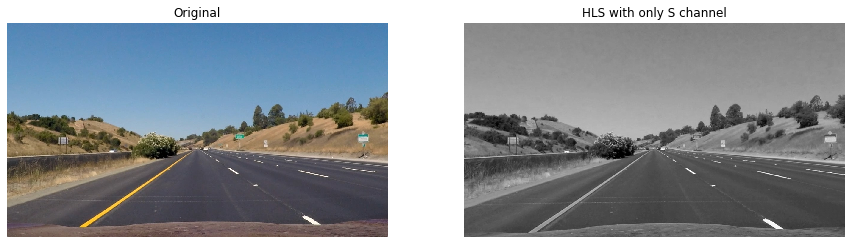

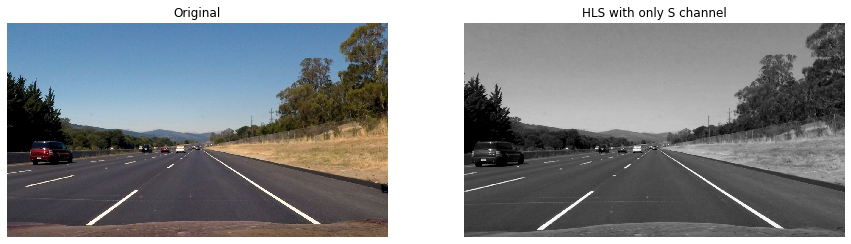

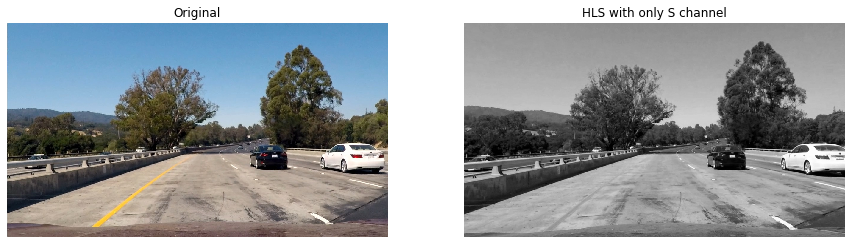

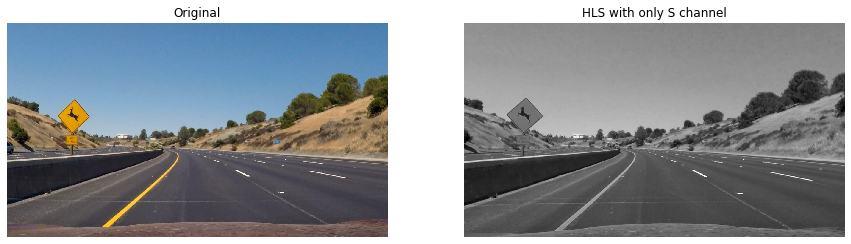

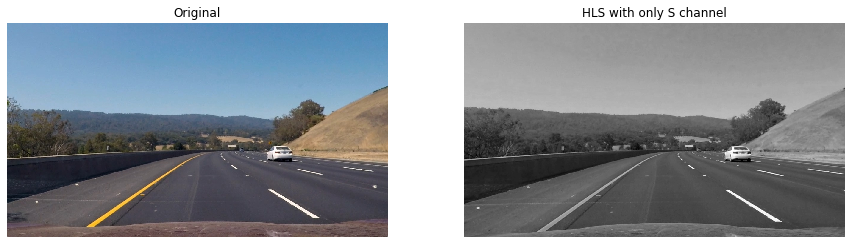

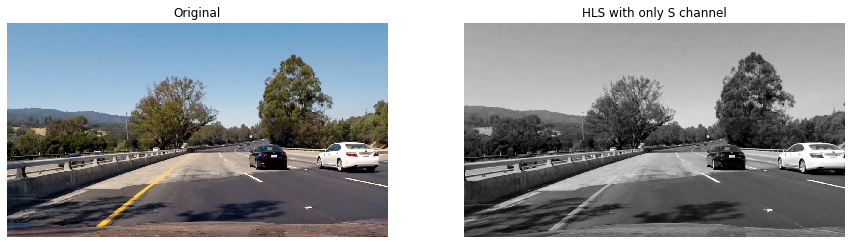

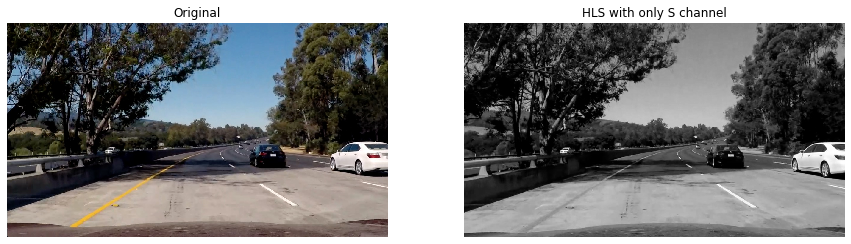

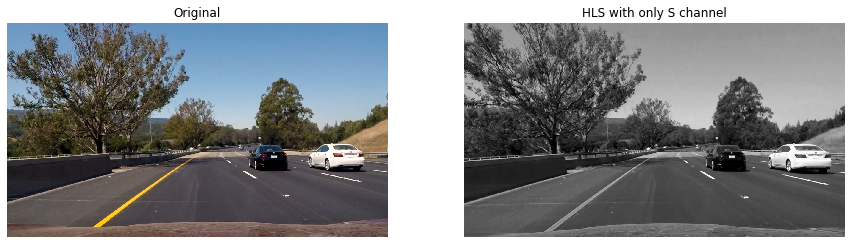

In [6]:
# Loading the camera calibration
cameraCalib = pickle.load(open('serialized_camera_calibration/camera_calibration.p','rb'))

mtx, dist = map(cameraCalib.get, ('mtx','dist'))
hls_list = []

for ori in img:
    undist = cv2.undistort(ori[1], mtx, dist, None, mtx)
    
    # Converting the color space from RGB to HLS
    # Selecting only the S channel as this gives the best contrast
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)[:,:,1]
    show_images([('Original',ori[1]),('HLS with only S channel',hls)], rows=1, cols=2, cmap='gray')
    hls_list.append(hls)

## The Sobel Operator aka the Sobel Edge Detector

The Canny Edge detector is actually an optimised general purpose algorithm which uses the Sobel operator, however, we will like to optimised it for lane line detection. A very good explanation of the sobel edge detector can be found [here].

Also read the [OpenCV Sobel Documentation].

Due to saving the computational power, we can only convolute the Sobel kernel in the X direction.

[here]:https://www.youtube.com/watch?v=uihBwtPIBxM
[OpenCV Sobel Documentation]:https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/sobel_derivatives/sobel_derivatives.html

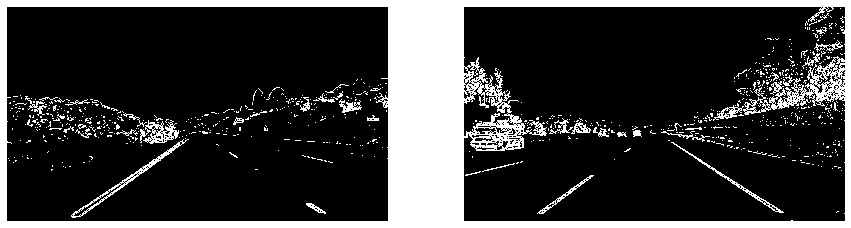

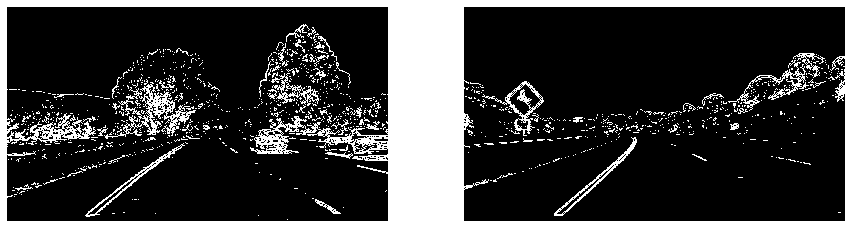

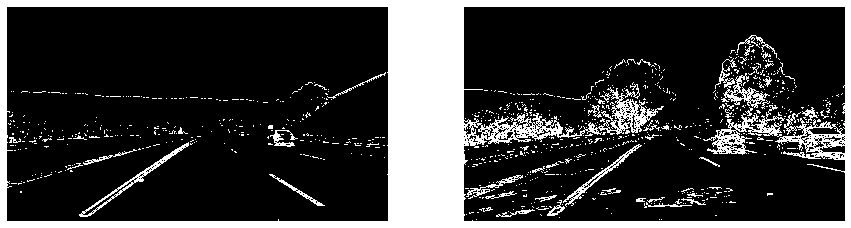

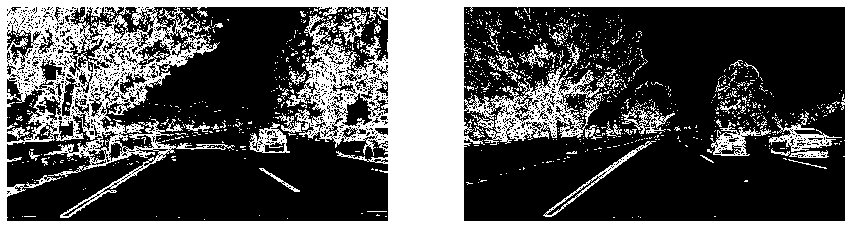

In [91]:
def img_thres(img, tmin, tmax):
    """
    To apply a threshold to the img and returning a binary image of 
    either 0 or 255
    """
    binary_img = np.zeros_like(img)
    binary_img[(img >= tmin) & (img <= tmax)] = 1
    return binary_img

def edge_detector(img, sobel_kernel=3, tmin=0, tmax=255):
   
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    return img_thres(gradmag, tmin, tmax)

for i in range(0,4+len(hls_list)//2,2):
    img1 = edge_detector(hls_list[i], 3, 20, 250)
    img2 = edge_detector(hls_list[i+1], 3, 20, 250)
    show_images([('',img1),('',img2)], rows=1, cols=2, cmap='gray')
    